In [22]:
# importing required libraries
import numpy as np
import pandas as pd

import datetime as dt
import yfinance as yf
import pandas_datareader.data as web
import cpi
import wbdata
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, LeakyReLU
from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt


cpi.update()


In [27]:
# importing sp500 list of stocks
sp500_stocks = pd.read_csv("/content/drive/MyDrive/DS4420/Project/sp500_stocks.csv", encoding="latin-1")
#print(sp500_stocks)

# using ticker list as stock list coz want to run idea by calvin
stock_list = list(sp500_stocks["Ticker"])

# defining start and end date
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2024, 12, 31)

In [3]:
# # customize seed for different stocks
# np.random.seed(42)

# # list of all potential stocks
# ticker_list = ['AAPL','AXP', 'BAC', 'C', 'CSCO', 'GS', 'IBM', 'INTC', 'JPM', 'MSFT', 'NVDA', 'CRM', 'QCOM', 'NOW', 'ORCL', 'AVGO', 'GDDY',
#                'WIX', 'TSM', 'TSLA', 'SNOW', 'HUBS', 'DOCU', 'MS']

# # selecting 15 random stocks
# stock_list = np.random.choice(ticker_list,15,replace=False)
# stock_list = list(np.sort(stock_list))
# print(f'These are the fifteen stocks assigned to you: {" ".join(stock_list)}')

# # defining start and end date
# start = dt.datetime(2000, 1, 1)
# end = dt.datetime(2024, 12, 31)

# # getting returns of the stocks
# # calculates returns using adjusted close price
# # ensures that we have returns of only those dates where all companies have available information
# returns = yf.download(stock_list, start-pd.offsets.BDay(1), end+pd.offsets.BDay(1), auto_adjust=False)['Adj Close'].pct_change().dropna()

# # gets all returns Close, high, low, open, volume
# #returns = yf.download(stock_list, start, end)

# # S&P 500
# sp500 = yf.Ticker("^GSPC")
# sp500_data = sp500.history(period="25y")
# sp500_data['SP500'] = sp500_data['Close'].pct_change()
# sp500_data = sp500_data.drop(columns=["Open", "High", "Low", "Close", "Volume", "Dividends", "Stock Splits"])

# sp500_data.index = sp500_data.index.strftime('%m-%d-%Y')
# sp500_data.index = pd.to_datetime(sp500_data.index)
# # sp500_mon = sp500_data.resample(rule = 'ME').apply(lambda x: x.add(1).prod().sub(1))




In [4]:
# getting prices of the stocks
prices = yf.download(stock_list, start-pd.offsets.BDay(1), end+pd.offsets.BDay(1), auto_adjust=False)['Adj Close']

NameError: name 'yf' is not defined

In [ ]:
# defining empty list
filtered_stocks = []

for i in prices.columns:
    # getting stocks who had some prices in 2005 jan
    if prices.loc[pd.Timestamp("2005-01-03"), i] >= 0:

        # adding them to filtered list
        filtered_stocks.append(i)

# getting df
filtered_df = prices[filtered_stocks]
#print(filtered_df)

# dropping null values
filtered_df = filtered_df.dropna()

# getting daily returns
returns = filtered_df.pct_change().dropna()
#returns

In [ ]:
# getting a sector analysis
sp500_stocks[sp500_stocks["Ticker"].isin(stock_list)]["Sector"].value_counts(normalize=True)

,proportion
Sector,
Technology,0.163022
Industrials,0.139165
Financials,0.135189
Healthcare,0.121272
Consumer Discretionary,0.109344
Consumer Staples,0.073559
Utilities,0.063618
Real Estate,0.061630
Communication Services,0.047714


In [ ]:
# S&P 500
sp500 = yf.Ticker("^GSPC")
sp500_data = sp500.history(period="21y")
sp500_data['SP500'] = sp500_data['Close'].pct_change()
sp500_data = sp500_data.drop(columns=["Open", "High", "Low", "Close", "Volume", "Dividends", "Stock Splits"])

sp500_data.index = sp500_data.index.strftime('%m-%d-%Y')
sp500_data.index = pd.to_datetime(sp500_data.index)
# sp500_mon = sp500_data.resample(rule = 'ME').apply(lambda x: x.add(1).prod().sub(1))

#sp500_data

In [ ]:
# Find finding monthly returns
returns = pd.merge(returns, sp500_data, left_index = True, right_index = True )

returns_mon = returns.resample(rule = 'ME').apply(lambda x: x.add(1).prod().sub(1))

returns_mon

,A,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,...,WST,WTW,WY,WYNN,XEL,XOM,YUM,ZBH,ZBRA,SP500
Date,,,,,,,,,,,,,,,,,,,,,
2004-12-31,-0.003308,-0.013178,0.051860,-0.005141,-0.012797,0.001646,-0.028166,0.029059,0.002713,0.090789,...,0.045531,0.002619,-0.000595,0.004353,0.008103,0.014849,0.020329,-0.016933,0.019381,0.005142
2005-01-31,-0.082572,0.194100,-0.029582,-0.050904,-0.035185,-0.093083,-0.027898,0.084716,-0.019617,-0.226087,...,0.047275,-0.060481,-0.071705,-0.020323,-0.000549,0.006633,-0.015475,-0.015851,-0.095060,-0.025290
2005-02-28,0.085482,0.166710,0.021546,0.129322,-0.019194,0.085237,0.024811,-0.000680,-0.011959,0.011917,...,-0.015326,0.022492,0.079472,0.091672,-0.025838,0.232947,0.052427,0.089410,-0.020813,0.018903
2005-03-31,-0.075000,-0.071110,0.013698,-0.034716,-0.054794,0.087987,-0.015795,0.019917,0.050084,0.001862,...,-0.070039,-0.062192,0.023458,-0.053514,-0.018408,-0.058601,0.062116,-0.094179,-0.047724,-0.019118
2005-04-30,-0.065315,-0.134630,0.060572,-0.001249,-0.101449,-0.114634,-0.056171,-0.268104,-0.033593,0.069556,...,0.107255,-0.092759,0.001606,-0.218483,0.000000,-0.043121,-0.091839,0.046395,0.005685,-0.020109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.010750,0.032353,0.069190,0.180727,0.034269,0.041258,0.014954,-0.008044,0.050606,0.043956,...,0.024366,0.034824,-0.033649,-0.068670,0.050618,0.002526,0.020802,0.036911,-0.016544,0.022835
2024-09-30,0.038903,0.017467,0.006533,-0.010699,0.033718,-0.098588,-0.016031,-0.020495,0.008041,0.066099,...,-0.042949,0.011322,0.110528,0.247138,0.075697,-0.006105,0.035503,-0.062966,0.072210,0.020197
2024-10-31,-0.120976,-0.030429,-0.000927,-0.119056,-0.020529,-0.076674,-0.030673,-0.075829,0.045206,0.030202,...,0.025886,0.026007,-0.079740,0.001460,0.023124,-0.003754,-0.061198,-0.009541,0.031459,-0.009897


In [ ]:
# Standard deviation for 2018, May SP500
sp500_stdev = returns.loc[(returns.index.year == 2018) & (returns.index.month == 5)]['SP500'].std()
print(f"The standard deviation for SP500 in May of 2018 is {sp500_stdev}")

# Calculating STDEV for each month
monthly_std = returns.groupby(by=[returns.index.month, returns.index.year]).std()
monthly_std.index = pd.to_datetime(monthly_std.index.map(lambda x: f"{x[1]}-{x[0]}"), format="%Y-%m")
monthly_std.sort_index(inplace=True)
monthly_std.index = returns_mon.index

# Double check
monthly_std

The standard deviation for SP500 in May of 2018 is 0.006550294321030806


,A,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,...,WST,WTW,WY,WYNN,XEL,XOM,YUM,ZBH,ZBRA,SP500
Date,,,,,,,,,,,,,,,,,,,,,
2004-12-31,0.011183,0.017300,0.015261,0.010422,0.009260,0.013331,0.011534,0.013200,0.007679,0.023779,...,0.031860,0.010922,0.005320,0.021756,0.008197,0.012592,0.005305,0.012896,0.011176,0.004724
2005-01-31,0.015337,0.028358,0.010376,0.007567,0.016653,0.013558,0.014966,0.020805,0.013980,0.037855,...,0.009331,0.011721,0.010742,0.024634,0.007796,0.009590,0.009465,0.012896,0.019924,0.006447
2005-02-28,0.018691,0.022854,0.009947,0.012481,0.013030,0.021544,0.020865,0.021208,0.009512,0.026762,...,0.015225,0.011469,0.013033,0.019286,0.012277,0.014524,0.011436,0.027411,0.022322,0.006730
2005-03-31,0.013886,0.022648,0.010224,0.008496,0.011023,0.018118,0.015624,0.013201,0.004762,0.013132,...,0.016013,0.010998,0.011658,0.020187,0.010194,0.014474,0.013788,0.017879,0.015793,0.006339
2005-04-30,0.015846,0.035998,0.014212,0.007616,0.014506,0.031022,0.014443,0.047626,0.012181,0.023370,...,0.040541,0.013907,0.021138,0.027074,0.008504,0.020634,0.013108,0.014508,0.015706,0.009503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.013861,0.014390,0.011846,0.012121,0.011381,0.016783,0.029006,0.010993,0.008371,0.018378,...,0.018602,0.010168,0.012885,0.021677,0.012369,0.013174,0.009026,0.015038,0.019970,0.012262
2024-09-30,0.016580,0.014810,0.011136,0.010678,0.018660,0.023263,0.024488,0.016036,0.009211,0.011440,...,0.018413,0.007523,0.013204,0.027843,0.007073,0.016501,0.013090,0.021166,0.018367,0.008719
2024-10-31,0.011671,0.013200,0.009935,0.022443,0.013401,0.015289,0.017170,0.012342,0.007570,0.012356,...,0.038040,0.012459,0.014881,0.019485,0.015597,0.012030,0.007329,0.017107,0.015557,0.006936


In [ ]:
# Finding other features we care about
# Finding risk free-rate
rf = web.DataReader('F-F_Research_Data_Factors','famafrench', start, end)[0][['RF']].div(100)
rf.index = rf.index.to_timestamp(how='end').normalize()

# CPI data from FRED
cpi = web.DataReader('CPIAUCSL', 'fred', start, end)

# Calculate monthly inflation rates as percentage change
inflation_rate = cpi.pct_change().dropna()
inflation_rate.index = inflation_rate.index.to_period('M').to_timestamp(how='end').normalize()
inflation_rate.columns = ['Inflation Rate']

# Rolling Average
rolling_avg = returns.rolling(window=30).mean()
rolling_avg.columns = [name+"_ROLL_AVG" for name in rolling_avg.columns]
rolling_monthly = rolling_avg.resample('M').last()

<ipython-input-36-5199d6a4b315>:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  rf = web.DataReader('F-F_Research_Data_Factors','famafrench', start, end)[0][['RF']].div(100)
<ipython-input-36-5199d6a4b315>:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  rf = web.DataReader('F-F_Research_Data_Factors','famafrench', start, end)[0][['RF']].div(100)
<ipython-input-36-5199d6a4b315>:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rolling_monthly = rolling_avg.resample('M').last()


In [ ]:
# Creating the final df
result = pd.concat([returns_mon, monthly_std], axis=1, keys=['RETURN', 'STDEV'])
result.columns = result.columns.get_level_values(1) + '_' + result.columns.get_level_values(0).astype(str)

result = pd.merge(result, rf, how='left', left_index=True, right_index=True)
result = pd.merge(result, inflation_rate, how = 'left', left_index=True, right_index=True)
result = pd.merge(result, rolling_monthly, how = 'left', left_index=True, right_index=True)

# Removing first two rows because rolling average has errors
result = result.iloc[2:]

result.head()

,A_RETURN,AAPL_RETURN,ABT_RETURN,ACGL_RETURN,ACN_RETURN,ADBE_RETURN,ADI_RETURN,ADM_RETURN,ADP_RETURN,ADSK_RETURN,...,WST_ROLL_AVG,WTW_ROLL_AVG,WY_ROLL_AVG,WYNN_ROLL_AVG,XEL_ROLL_AVG,XOM_ROLL_AVG,YUM_ROLL_AVG,ZBH_ROLL_AVG,ZBRA_ROLL_AVG,SP500_ROLL_AVG
Date,,,,,,,,,,,,,,,,,,,,,
2005-02-28,0.085482,0.166710,0.021546,0.129322,-0.019194,0.085237,0.024811,-0.000680,-0.011959,0.011917,...,0.000559,0.000067,0.000489,0.003326,-0.000229,0.007779,0.002467,0.003826,-0.000568,0.000754
2005-03-31,-0.075000,-0.071110,0.013698,-0.034716,-0.054794,0.087987,-0.015795,0.019917,0.050084,0.001862,...,-0.003771,-0.000624,0.003027,-0.002970,-0.001402,0.001677,0.002581,-0.002082,-0.001548,-0.000801
2005-04-30,-0.065315,-0.134630,0.060572,-0.001249,-0.101449,-0.114634,-0.056171,-0.268104,-0.033593,0.069556,...,0.003700,-0.003257,0.000897,-0.010352,0.000075,-0.002336,-0.002288,0.000646,0.000080,-0.000911
2005-05-31,0.157109,0.102607,-0.018715,0.116529,0.072811,0.113839,0.090030,0.108214,0.008287,0.243481,...,0.006289,-0.000905,-0.000478,-0.007291,0.002739,-0.000279,0.001147,-0.000026,-0.001984,0.001331
2005-06-30,-0.041233,-0.074195,0.015962,0.008959,-0.026203,-0.136171,0.006202,0.077078,-0.038371,-0.132390,...,-0.000370,-0.000877,-0.000675,0.000642,0.002916,0.002375,0.000457,-0.000513,0.001724,0.000173


# MLP
LSTM

In [ ]:
def test_train_split(stock):
    """
    Function that splits the data into training & testing data

    Parameters:
        Stock (str): Ticker of the stock

    Returns:
        df (dataframe): dataframe that contains stock return, stddev, roll_avg,
                        sp500 data, rf, inflation rate
        X_train (array): training features
        X_test (array): testing features
        y_train (array): training target
        y_test (array): testing target

    """

    # filtering the dataframe for input stock and merging it with the macroeconomic factors
    df = pd.concat([result.filter(like = stock),result[['SP500_RETURN','SP500_STDEV', 'RF', 'Inflation Rate']]], axis=1)

    # sorting dataframe
    df.sort_index(inplace=True)

    # # Including past historical distorts the result
    # aapl = aapl.loc[(aapl.index.year >= 2022)]

    # shift target variable
    df[f"Next_{stock}_RETURN"] = df[f"{stock}_RETURN"].shift(-1)

    # NaN in last row because of the shift
    df.dropna(inplace=True)

    # defining target and features
    features = [col for col in df.columns if col not in [f"Next_{stock}_RETURN"]]
    target = f"Next_{stock}_RETURN"

    X = df[features]
    y = df[target]

    # normalizing and splitting the data
    # scaler = StandardScaler()
    scaler = MinMaxScaler()

    # 80% training, 20% testing
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # reshaping because lstm needs 3d input
    X_train = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    return df, X_train, X_test, y_train, y_test

In [ ]:
def lstm(X_train, X_test, y_train, y_test):
    """
    ML Model #1: LSTM model to predict stock returns

    Parameters:
        X_train (array): training features
        X_test (array): testing features
        y_train (array): training target
        y_test (array): testing target

    Returns:
        None

    """

    # defining the model
    model = Sequential([LSTM(50, return_sequences=True),  # , input_shape=(X_train.shape[1], X_train.shape[2])),
                        LSTM(50), LeakyReLU(alpha=0.01), Dense(1)])

    # compiling the model
    model.compile(optimizer="adam", loss="mse")

    # fitting the model
    model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test))

    # next_month_pred = model.predict(X_test[-1].reshape(1, 1, X_test.shape[2]))
    # print("Predicted Return for Next Month:", next_month_pred[0][0])

    # getting predictions
    y_pred = model.predict(X_test)
    y_test_copy = y_test.values.reshape(-1,1)

    Y = np.hstack((y_pred, y_test_copy))
    print('Side by side comparison y_pred vs y')
    print(Y)

    # plotting the data
    plt.plot(y_test, label = "actual return")
    plt.plot(pd.Series(y_pred.flatten(), index=y_test.index), label = "predictions")
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Returns')
    plt.show()

    print('The Mean Squared Error is:', mean_squared_error(y_pred,y_test_copy))


Enter the stock ticker: MSFT
Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 2/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 3/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 4/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 5/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 6/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 7/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 8/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 9/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 10/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 11/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 12/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0044 - val_loss: 0.0042


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step
Side by side comparison y_pred vs y
[[ 0.00556465  0.04289188]
 [ 0.01830697  0.00411794]
 [ 0.04951562  0.01458827]
 [ 0.00575317  0.06960162]
 [ 0.00801205 -0.00762726]
 [ 0.00525051  0.0849887 ]
 [-0.00666146  0.05171677]
 [ 0.01970611  0.06159093]
 [ 0.00661086 -0.06611891]
 [ 0.02438626  0.17629071]
 [-0.06828998 -0.00128192]
 [ 0.03081699  0.01733266]
 [ 0.01357058 -0.07534473]
 [ 0.00240711 -0.0372121 ]
 [ 0.01847596  0.0318618 ]
 [ 0.02643405 -0.09986711]
 [-0.04469138 -0.01807705]
 [ 0.03034752 -0.05532071]
 [-0.06396066  0.09309674]
 [ 0.04058022 -0.06666298]
 [ 0.00897057 -0.10926704]
 [-0.01910677 -0.00330605]
 [ 0.04724545  0.10222308]
 [ 0.00766172 -0.06004558]
 [ 0.02452847  0.03331658]
 [ 0.02016078  0.00901784]
 [ 0.02358857  0.15588169]
 [-0.04184664  0.06576486]
 [ 0.01106958  0.07110559]
 [ 0.05387343  0.03699879]
 [ 0.03872686 -0.0135667 ]
 [ 0.01356423 -0.02222578]
 [-0.00880624 -0.03664273]
 [ 0.03411791  0.07081555]
 [-0.03

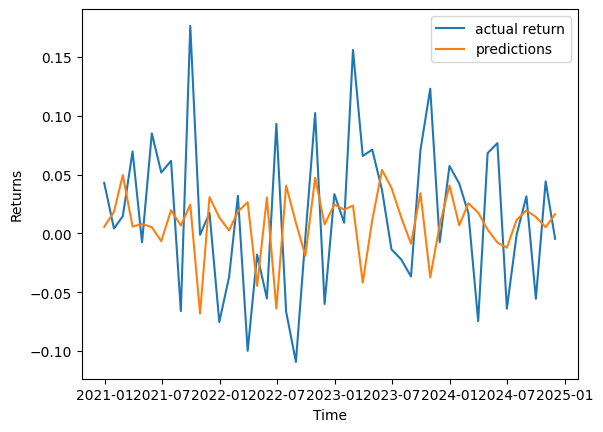

The Mean Squared Error is: 0.004996408641873937


In [ ]:
# testing with MSFT
input_stock = input("Enter the stock ticker: ")
df, X_train, X_test, y_train, y_test = test_train_split(input_stock)

lstm(X_train, X_test, y_train, y_test)

In [ ]:
# preds = {}

# for stock in stock_list:
#     next_month_pred = lstm_pred(stock)

#     preds[stock] = next_month_pred

# preds


In [ ]:
# aapl = pd.concat([result.filter(like = 'AAPL'),result[['SP500_RETURN','SP500_STDEV', 'RF', 'Inflation Rate']]], axis=1)

# # # Including past historical distorts the result
# # aapl = aapl.loc[(aapl.index.year >= 2022)]

# # To ensure that it is sequentially ordered
# aapl.sort_index(inplace=True)

# # shift target variable
# aapl["Next_AAPL_RETURN"] = aapl["AAPL_RETURN"].shift(-1)
# # NaN in last row because of the shift
# aapl.dropna(inplace=True)

# # Defining target and features
# features = [col for col in aapl.columns if col not in ["Next_AAPL_RETURN"]]
# target = "Next_AAPL_RETURN"

# X = aapl[features]
# y = aapl[target]

# # Normalize and split the data
# # scaler = StandardScaler()
# scaler = MinMaxScaler()

# train_size = int(len(X) * 0.8)
# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # reshaping because lstm needs 3d input
# X_train = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
# X_test = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# model = Sequential([
#     LSTM(50, return_sequences=True, input_shape=(1, X_train.shape[2])),
#     LSTM(50),
#     Dense(25, activation='relu'),
#     Dense(1)
# ])

# model.compile(optimizer="adam", loss="mse")

# model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))





In [ ]:
# start = dt.datetime(2000, 1, 1)
# end = dt.datetime(2025, 2,2)

# returns = yf.download(stock_list, start-pd.offsets.BDay(1), end+pd.offsets.BDay(1), auto_adjust=False)['Adj Close'].pct_change().dropna()
# check_returns_mon = returns.resample(rule = 'ME').apply(lambda x: x.add(1).prod().sub(1))

# check_returns_mon

In [ ]:
# next_month_pred = model.predict(X_test[-1].reshape(1, 1, X_test.shape[2]))
# print("Predicted AAPL Return for Next Month:", next_month_pred[0][0])

# y_pred = model.predict(X_test)
# y_test_copy = y_test.values.reshape(-1,1)

# Y = np.hstack((y_pred, y_test_copy))
# print('Side by side comparison y_pred vs y')
# print(Y)

In [ ]:
# plt.plot(y_test, label = "actual return")
# plt.plot(pd.Series(y_pred.flatten(), index=y_test.index), label = "predictions")
# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('Returns')
# plt.show()